In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage import morphology
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from config import *

CATEGORIES_REVERSE = {v: k for k, v in CATEGORIES_CODES.items()}

In [60]:
class DataLoader:
    __slots__ = ('images', '__index', 'labels', '_size', 'data')
    shape = (224, 224, 1)
    
    def __init__(self, _path: str) -> None:
        self.data = pd.read_csv(_path)
        self.__index, self._size = 0, self.data.shape[0]
        
        self.images = np.empty((self._size,) + self.shape, dtype='float16')
        self.labels = np.empty(self._size, dtype='uint8')

    def load_data(self) -> None:
        for _, _path, _categories in self.data.values:
            self.add_image(_path, _categories)

    def add_image(self, _path: str, category: int) -> None:
        image_path = f"data/train/{CATEGORIES_REVERSE[category]}/{_path}"
        img = cv2.imread(image_path, 0) / 255
        
        img.reshape(224, 224)
        img = morphology.skeletonize(img < 0.5)
        
        self.images[self.__index] = np.asarray(img, dtype='float16').reshape(self.shape)
        self.labels[self.__index] = category
        self.__index += 1

        print(f"[+] Progress: {self.__index}/{self._size}", end='\r')
        
        if self.__index == self._size:
            self.labels = to_categorical(self.labels)
            print(f"\n[+] DONE {self._size}/{self._size}")
            
    def show_image(self, index: int) -> None:
        plt.imshow(self.images[index], cmap='gray')

[+] Progress: 14629/14629
[+] DONE 14629/14629


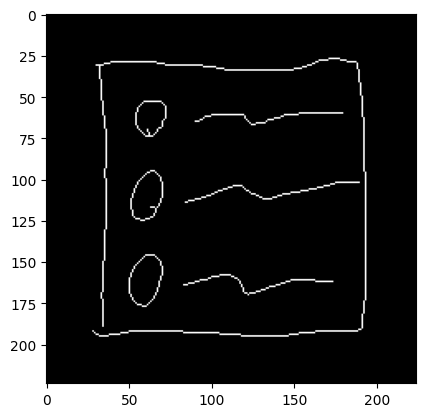

In [61]:
train_set_path = 'data/processed/train_set.csv'
train_data = DataLoader(train_set_path)
train_data.load_data()
train_data.show_image(302)

In [62]:
class SketchClassificatorModel:
    __slots__ = ('_data', '_shape', 'num_classes', 'model', 'version')
    
    def __init__(self, data, _version: str) -> None:
        self._data = data
        self._shape = data.shape
        self.num_classes = len(CATEGORIES_CODES)
        self.model = models.Sequential()
        self.version = _version

    def build_model(self) -> None:
        activation, final_activation = 'relu', 'softmax'
        kernel_size, pool_size = (6, 6), (4, 4)
        
        self.model.add(layers.Conv2D(32, kernel_size, activation=activation, input_shape=self._shape))
        self.model.add(layers.MaxPooling2D(pool_size=pool_size))
        self.model.add(layers.Conv2D(64, kernel_size=kernel_size, activation=activation))
        self.model.add(layers.Dropout(0.4))
        self.model.add(layers.MaxPooling2D(pool_size=pool_size))
        self.model.add(layers.Conv2D(128, kernel_size=kernel_size, activation=activation))
        self.model.add(layers.Flatten())
        self.model.add(layers.Dense(128, activation=activation))
        self.model.add(layers.Dropout(0.4))
        self.model.add(layers.Dense(self.num_classes, activation=final_activation))
        
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    def train(self) -> None:
        self.model.fit(self._data.images, self._data.labels, epochs=12, batch_size=64, validation_split=0.05)
    
    def save(self) -> None:
        self.model.save(f'models/model_v{self.version}.h5')

[+] Progress: 770/770
[+] DONE 770/770


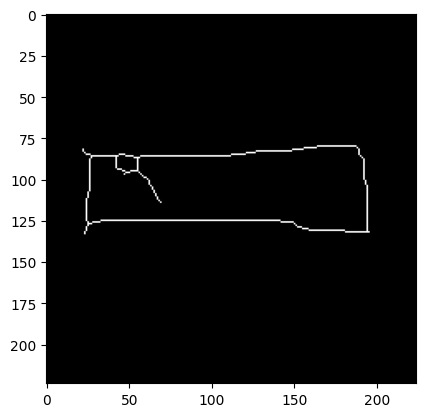

In [63]:
test_set_path = 'data/processed/test_set.csv'
test_data = DataLoader(test_set_path)
test_data.load_data()
test_data.show_image(300)

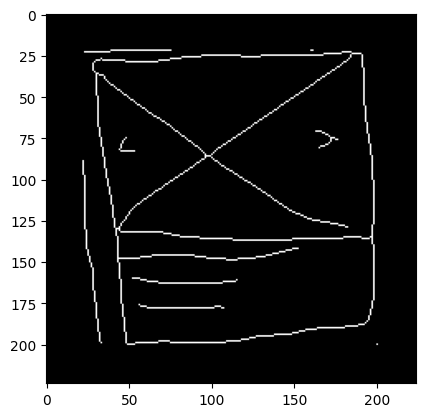

In [65]:
test_data.show_image(345)

In [66]:
new_model_version = '0.1.7'   
sketch_model = SketchClassificatorModel(train_data, new_model_version)
sketch_model.build_model()
sketch_model.train()
sketch_model.save()

del sketch_model

Epoch 1/12
218/218 [==============================] - 94s 429ms/step - loss: 2.0664 - accuracy: 0.3817 - val_loss: 1.5453 - val_accuracy: 0.5738
Epoch 2/12
218/218 [==============================] - 98s 451ms/step - loss: 1.3582 - accuracy: 0.5834 - val_loss: 1.2153 - val_accuracy: 0.6434
Epoch 3/12
218/218 [==============================] - 97s 446ms/step - loss: 1.0961 - accuracy: 0.6608 - val_loss: 1.0750 - val_accuracy: 0.6694
Epoch 4/12
218/218 [==============================] - 96s 441ms/step - loss: 0.9291 - accuracy: 0.7120 - val_loss: 0.9966 - val_accuracy: 0.7186
Epoch 5/12
218/218 [==============================] - 98s 448ms/step - loss: 0.7764 - accuracy: 0.7534 - val_loss: 0.9278 - val_accuracy: 0.7363
Epoch 6/12
218/218 [==============================] - 97s 444ms/step - loss: 0.6583 - accuracy: 0.7908 - val_loss: 0.8921 - val_accuracy: 0.7240
Epoch 7/12
218/218 [==============================] - 97s 444ms/step - loss: 0.5809 - accuracy: 0.8113 - val_loss: 0.8614 - val_ac

D:\it\ML\IASA-Champ-24-stage1\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [67]:
for models in os.listdir('models'):
    model_test = load_model(f'models/{models}')
    print(f'Model version: {models[6:-3]}')
    test_loss, test_accuracy = model_test.evaluate(test_data.images, test_data.labels)

Model version: v0.1.1
25/25 [==============================] - 3s 110ms/step - loss: 2.7565 - accuracy: 0.5727
Model version: v0.1.2
25/25 [==============================] - 2s 60ms/step - loss: 2.1216 - accuracy: 0.6065
Model version: v0.1.3
25/25 [==============================] - 2s 61ms/step - loss: 1.7393 - accuracy: 0.5857
Model version: v0.1.4
25/25 [==============================] - 2s 61ms/step - loss: 2.0144 - accuracy: 0.5844
Model version: v0.1.5
25/25 [==============================] - 2s 61ms/step - loss: 1.4803 - accuracy: 0.6260
Model version: v0.1.6
25/25 [==============================] - 2s 61ms/step - loss: 1.8728 - accuracy: 0.5818
Model version: v0.1.7
25/25 [==============================] - 2s 61ms/step - loss: 0.9591 - accuracy: 0.7429
Model version: v0.1.8
25/25 [==============================] - 2s 61ms/step - loss: 2.6016 - accuracy: 0.5844
Model version: v0.1.9
25/25 [==============================] - 2s 61ms/step - loss: 2.7314 - accuracy: 0.5792
Model ver